In [1]:
!pip install bayesian-optimization

In [2]:
#!unzip -o '/content/Assignment4data.zip'

Archive:  /content/Assignment4data.zip
 extracting: Assignment4data/README.txt  
 extracting: Assignment4data/test_X.npy  
 extracting: Assignment4data/test_y.npy  
 extracting: Assignment4data/train_X.npy  
 extracting: Assignment4data/train_y.npy  


In [3]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import copy
from bayes_opt import BayesianOptimization
from functools import partial

In [4]:
X_train = np.load('Assignment4data/train_X.npy', allow_pickle=True)
y_train = np.load('Assignment4data/train_y.npy', allow_pickle=True)
X_test = np.load('Assignment4data/test_X.npy', allow_pickle=True)
y_test = np.load('Assignment4data/test_y.npy', allow_pickle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 28*28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).view(-1, 28*28)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 28*28)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_val_tensor, y_val_tensor)


In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes, activation=nn.ReLU()):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
def evaluate_f1(model, val_dataset):
    model.eval()
    y_true = []
    y_pred = []
    for inputs, targets in val_dataset:
        outputs = model(inputs)
        predicted = torch.argmax(outputs)
        y_true.append(targets.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

In [7]:
def objective_function(batch_size, activation_index, train_dataset):
    activation_funcs = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
    activation_func = activation_funcs[int(activation_index)]

    model = NeuralNet(28*28, 10, activation_func)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    train_loader = DataLoader(dataset=train_dataset, batch_size=int(batch_size), shuffle=True)

    for epoch in range(10):
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    val_f1_score = evaluate_f1(model, val_dataset)
    return val_f1_score

In [8]:
optimizer = BayesianOptimization(
    f=partial(objective_function, train_dataset=train_dataset),
    pbounds={'batch_size': (16, 1024), 'activation_index': (0, 2)},
    random_state=1,
)

In [9]:
optimizer.maximize(init_points=2, n_iter=100)

|   iter    |  target   | activa... | batch_... |
-------------------------------------------------
| 1         | 0.6922    | 0.834     | 742.1     |
| 2         | 0.7882    | 0.0002287 | 320.8     |
| 3         | 0.8092    | 0.0879    | 322.1     |
| 4         | 0.7877    | 0.4744    | 327.3     |
| 5         | 0.7937    | 0.3479    | 339.9     |
| 6         | 0.7528    | 1.482     | 345.9     |
| 7         | 0.7996    | 0.3018    | 334.7     |
| 8         | 0.8184    | 1.775     | 466.8     |
| 9         | 0.7938    | 1.523     | 462.8     |
| 10        | 0.7511    | 0.3362    | 470.8     |
| 11        | 0.812     | 1.963     | 324.6     |
| 12        | 0.7377    | 0.1811    | 602.1     |
| 13        | 0.7963    | 1.727     | 452.3     |
| 14        | 0.6872    | 0.3305    | 446.9     |
| 15        | 0.813     | 1.816     | 456.7     |
| 16        | 0.856     | 1.084     | 178.4     |
| 17        | 0.8154    | 0.6636    | 175.0     |
| 18        | 0.7455    | 0.2709    | 181.9     |


In [10]:
best_params = optimizer.max['params']

In [11]:
activation_funcs = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
print(f"Activation: {activation_funcs[int(best_params['activation_index'])]}, Batch Size: {int(best_params['batch_size'])}")

Activation: Tanh(), Batch Size: 23


In [12]:
model = NeuralNet(28*28, 10, activation_funcs[int(best_params['activation_index'])])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_loader = DataLoader(dataset=train_dataset, batch_size=int(best_params['batch_size']), shuffle=True)

f1_log = []

for epoch in range(50):
    y_true = []
    y_pred = []
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = torch.argmax(outputs,1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        y_true.append(targets.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

    y_pred = [item for sublist in y_pred for item in sublist]
    y_true = [item for sublist in y_true for item in sublist]
    f1 = f1_score(y_true, y_pred, average='macro')
    f1_log.append(f1)

test_f1_score = evaluate_f1(model, test_dataset)
print(f'Test F1 score: {test_f1_score}')

Test F1 score: 0.9205162785017554


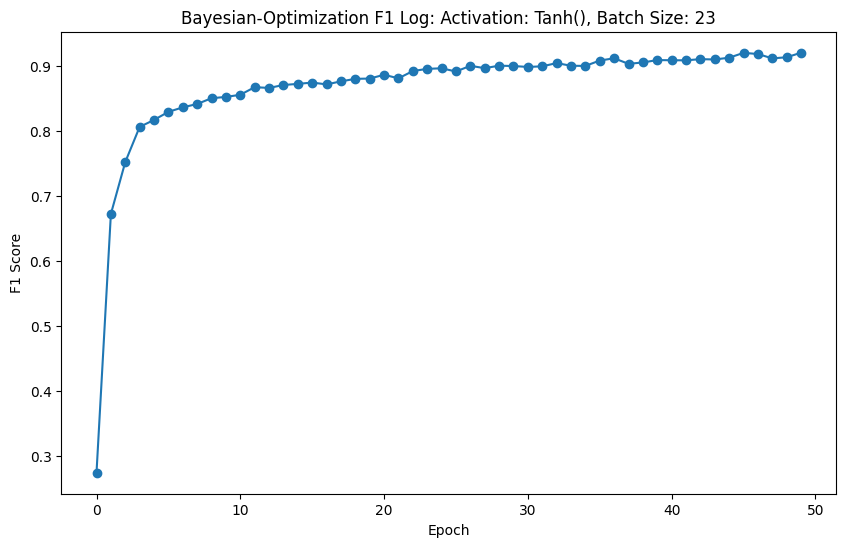

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(f1_log, marker='o')

plt.title(f'Bayesian-Optimization F1 Log: Activation: {activation_funcs[int(best_params["activation_index"])]}, Batch Size: {int(best_params["batch_size"])}')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.savefig('genetic_f1_log.png', dpi=300, format='png', bbox_inches='tight')

plt.show()